<a href="https://colab.research.google.com/github/Schumau/DS/blob/main/Copia_de_ProyectoDSParteII%2BSchuch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis de clientes bancarios**

## Introducción

En este análisis inicial busco comprender las características, ocupacionales y la relación de los clientes con la institución financiera. Este estudio utiliza un conjunto de datos proporcionado por un banco para explorar patrones clave de los clientes.
El análisis también explora la proporción de clientes con hipotecas activas y aquellos con deudas, identificando factores asociados al incumplimiento de pagos.

Los datos están relacionados con campañas de marketing directo (llamadas telefónicas) de una institución bancaria portuguesa. El objetivo de la clasificación es predecir si el cliente suscribirá un depósito a plazo (variable y).

Con frecuencia, era necesario contactar varias veces al mismo cliente para determinar si aceptaría o no el producto ofrecido, en este caso, un depósito bancario a plazo.

## Hipótesis

Hipótesis 1: los clientes jóvenes (menores de 30 años) tienen menos probabilidad de aceptar un depósito bancario a plazo en comparación con los clientes mayores.

Hipótesis 2: la probabilidad de éxito aumenta con cada contacto adicional realizado con un cliente.

Hipótesis 3: los clientes con préstamos personales activos tienen menos probabilidades de aceptar un depósito bancario.

Hipótesis 4: los clientes solteros tienen menos interés en los depósitos bancarios a plazo en comparación con los casados.

Hipótesis 5: las personas con un mayor nivel educativo tienen una mayor tasa de aceptación del producto.

##Inicio del análisis

In [171]:
!pip install mlxtend

In [172]:
!pip install joblib

Importamos las librearías que vamos a utilizar

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import matplotlib as mpl
import warnings
import plotly.graph_objects as go

import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression as lgr
from sklearn.neighbors import KNeighborsClassifier as knn
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from numpy import mean
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr

Importamos el archivo csv que vamos a analizar desde mi drive.

In [175]:
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/bank-additional-full.csv'

if os.path.exists(csv_file_path):
    print("El archivo CSV existe.")
else:
    print("El archivo CSV no se encuentra en la ruta especificada.")

try:
    df = pd.read_csv(csv_file_path)
    print('Archivo cargado con éxito.')
    print('Dimensiones del DataFrame:', df.shape)
except Exception as e:
        print(f"Ocurrió un error al cargar el archivo CSV: {e}")

El archivo CSV existe.
Archivo cargado con éxito.
Dimensiones del DataFrame: (41188, 1)


Cargamos el archivo con separación por " ; " ya que no separa las columnas y lee solo 1 con todos los datos

In [176]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Ahora nos da los mismos datos pero con 21 columnas

Nos aseguramos de esto:

In [177]:
df.shape

(41188, 21)

**DESCRIPCIÓN DE VARIABLES**

VARIABLES INPUT:

*Datos de los clientes del banco:*

• age: edad del cliente (variable numérica)

• job : tipo de trabajo del cliente (variable categórica)

• marital: estado civil del cliente (variable categórica)

• Education: nivel de educación del cliente (variable categórica)

• default: si el cliente tiene un préstamo/crédito en default (variable categórica)

• housing: si el cliente posee crédito hipotecario (variable categórica)

• loan: si el cliente posee préstamo personal (variable categórica)

*Datos relacionados con el último contacto de la actual campaña:*

• contact: tipo de contacto (variable categórica)

• month: mes del último contacto (variable categórica)

• day_of_week: día de la semana del último contacto (variable categórica)

• duration: duración de la último contacto - en segundos (variable numérica).

*Otros atributos:*

• campaign: cantidad de contactos realizados durante la campaña para el cliente (variable numérica)

• pdays: cantidad de días desde que el cliente fue contactado por última vez en otra campaña (variable numérica; 999 significa que el cliente no fue contactado anteriormente)

• previous: cantidad de contactos realizados previos a esta campaña para el cliente (variable numérica)

• poutcome: resultado de la campaña anterior (variable categórica)

*Atributos del contexto social y económico*

• emp.var.rate: Tasa de variación de empleo – indicador trimestral (variable numérica)

• cons.price.idx: Índice de precios al consumidor – indicador mensual (variable numérica)

• cons.conf.idx: Índice de confianza del consumidor - indicador mensual (variable numérica)

• euribor3m: tipo de interés aplicado a las operaciones entre bancos (tasa de 3 meses) – indicador diario (variable numérica)

• nr.employed: Cantidad de empleados – indicador trimestral (variable numérica)

VARIABLE OUTPUT (*Target*):

• y – si el cliente se ha suscripto a un plazo fijo (variable binaria)

Buscamos conocer la info del archivo

In [178]:
df.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

El dataset posee once variables categóricas y diez numéricas.

Debemos eliminar los datos que no brinden información extra como los duplicados, revisar datos faltantes, tomar decisiones sobre qué hacer con los valores missing o los valores nulls (eliminarlos o valorarlos), ver si hay columnas que no aportan información relevante y enlentecen nuestro código..


In [180]:
df.duplicated().sum()

12

Vemos que hay 12 duplicados, ahora veamos cuáles son

In [181]:
duplicados = df[df.duplicated(keep='first')]
print(duplicados)

       age          job   marital            education  default housing loan  \
1266    39  blue-collar   married             basic.6y       no      no   no   
12261   36      retired   married              unknown       no      no   no   
14234   27   technician    single  professional.course       no      no   no   
16956   47   technician  divorced          high.school       no     yes   no   
18465   32   technician    single  professional.course       no     yes   no   
20216   55     services   married          high.school  unknown      no   no   
20534   41   technician   married  professional.course       no     yes   no   
25217   39       admin.   married    university.degree       no      no   no   
28477   24     services    single          high.school       no     yes   no   
32516   35       admin.   married    university.degree       no     yes   no   
36951   45       admin.   married    university.degree       no      no   no   
38281   71      retired    single    uni

Así quedaría el archivo libre de duplicados

In [182]:
df[df.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


Seguimos, ahora buscamos saber si hay nulos

In [183]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


No hay nulos, asique procedemos a eliminar estos duplicados

In [184]:
df1 = df.drop_duplicates().reset_index(drop=True)
df1.shape

(41176, 21)

Eliminadas las filas repetidas, el dataset queda con 41.176 filas y 21 columnas.

**df1** va a ser nuestra dataframe a partir de este punto.

Realizamos un análisis de los principales indicadores estadísticos.

In [185]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,41176.0,40.023800,10.420680,17.000,32.000,38.000,47.000,98.000
duration,41176.0,258.315815,259.305321,0.000,102.000,180.000,319.000,4918.000
campaign,41176.0,2.567879,2.770318,1.000,1.000,2.000,3.000,56.000
pdays,41176.0,962.464810,186.937102,0.000,999.000,999.000,999.000,999.000
previous,41176.0,0.173013,0.494964,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41176.0,0.081922,1.570883,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41176.0,93.575720,0.578839,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41176.0,-40.502863,4.627860,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41176.0,3.621293,1.734437,0.634,1.344,4.857,4.961,5.045
nr.employed,41176.0,5167.034870,72.251364,4963.600,5099.100,5191.000,5228.100,5228.100


#**Análisis Exploratorio de Datos**

Vamos a realizar un primer análisis de las variables para ver la cantidad de categorías que poseen.

In [186]:
print('Age:\n', df1['age'].unique())
print('Jobs:\n', df1['job'].unique())
print('Marital:\n', df1['marital'].unique())
print('Education:\n', df1['education'].unique())
print('Default:\n', df1['default'].unique())
print('Housing:\n', df1['housing'].unique())
print('Loan:\n', df1['loan'].unique())
print('Contact:\n', df1['contact'].unique())
print('Month:\n', df1['month'].unique())
print('Day_of_week:\n', df1['day_of_week'].unique())
print('Duration:\n', df1['duration'].unique())
print('Campaign:\n', df1['campaign'].unique())
print('Pdays:\n', df1['pdays'].unique())
print('Previous:\n', df1['previous'].unique())
print('Poutcome:\n', df1['poutcome'].unique())
print('Emp.var.rate:\n', df1['emp.var.rate'].unique())
print('Cons.price.idx:\n', df1['cons.price.idx'].unique())
print('Cons.conf.idx:\n', df1['cons.conf.idx'].unique())
print('Euribor3m:\n', df1['euribor3m'].unique())
print('Nr.employed:\n', df1['nr.employed'].unique())
print('Y:\n', df1['y'].unique())

Age:
 [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
Jobs:
 ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Marital:
 ['married' 'single' 'divorced' 'unknown']
Education:
 ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Default:
 ['no' 'unknown' 'yes']
Housing:
 ['no' 'yes' 'unknown']
Loan:
 ['no' 'yes' 'unknown']
Contact:
 ['telephone' 'cellular']
Month:
 ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Day_of_week:
 ['mon' 'tue' 'wed' 'thu' 'fri']
Duration:
 [ 261  149  226 ... 1246 1556 1868]
Campaign:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 3

Vemos que aparece un valor 'Unknown' en el dataset, asique vamos a ver en qué proporción está y si es considerado valor faltante.

In [187]:
print('Hay un ' + str((df1['job']=='unknown').sum()/41188*100) +' % de registros Unknow en la columna job')
print('Hay un ' + str((df1['marital']=='unknown').sum()/41188*100) +' % de registros Unknow en la columna marital')
print('Hay un ' + str((df1['education']=='unknown').sum()/41188*100) +' % de registros Unknow en la columna education')
print('Hay un ' + str((df1['default']=='unknown').sum()/41188*100) +' % de registros Unknow en la columna default')
print('Hay un ' + str((df1['housing']=='unknown').sum()/41188*100) +' % de registros Unknow en la columna housing')
print('Hay un ' + str((df1['loan']=='unknown').sum()/41188*100) +' % de registros Unknow en la columna loan')

Hay un 0.8012042342429834 % de registros Unknow en la columna job
Hay un 0.1942313295134505 % de registros Unknow en la columna marital
Hay un 4.200252500728367 % de registros Unknow en la columna education
Hay un 20.87015635622026 % de registros Unknow en la columna default
Hay un 2.40361270272895 % de registros Unknow en la columna housing
Hay un 2.40361270272895 % de registros Unknow en la columna loan


Viendo el resultado, no eliminamos las filas que tienen valores 'Unknow' porque los toma como un valor mas para la variable y no como un valor faltante. Aclaro que no se consideró la variable 'age' ya que se aprecia en el anterior que no aparecía ningún valor 'Unknown'.

Analizamos la distribución de las adhesiones al plazo fijo preguntándonos, después de la campaña de marketing directo, ¿cuántos de nuestros clientes son propensos a adherirse a un plazo fijo?

In [188]:
df1["y"].value_counts()

,count
y,
no,36537
yes,4639


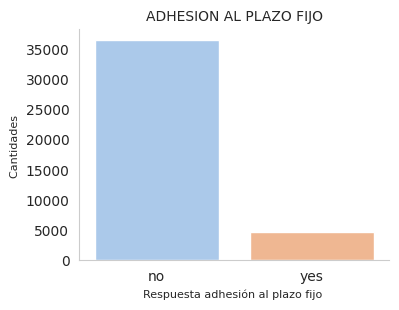

In [189]:
yon = sns.countplot(x="y", data=df1, palette= 'pastel', hue ='y')
yon.set_title("ADHESION AL PLAZO FIJO",  fontsize= 10)
yon.set_xlabel("Respuesta adhesión al plazo fijo ", fontsize= 8)
yon.set_ylabel("Cantidades ", fontsize= 8)
plt.gcf().set_size_inches(4, 3)
plt.grid(False)
yon.spines['right'].set_visible(False)
yon.spines['top'].set_visible(False)

Convertimos la variable target en numérica

In [190]:
df1['y'] = df1['y'].map({'no': 0, 'yes': 1})

In [191]:
df1['y'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 41176 entries, 0 to 41175
Series name: y
Non-Null Count  Dtype
--------------  -----
41176 non-null  int64
dtypes: int64(1)
memory usage: 321.8 KB


In [192]:
print('Y:\n', df1['y'].unique())

Y:
 [0 1]


In [193]:
df1

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41172,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41173,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41174,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


¿Cuál es el porcentaje de clientes propensos a adherirse a un plazo fijo?

In [194]:
count_no_adh = df1[df1['y'] == 0].shape[0]
count_adh = df1[df1['y'] == 1].shape[0]
total = count_no_adh + count_adh
pct_no_adh = round((count_no_adh / total) * 100)
pct_adh = round((count_adh / total) * 100)

print(f"El porcentaje de no adhesión al plazo fijo es del {pct_no_adh}% de los clientes,")
print(f"mientras que el porcentaje de adhesión al plazo fijo es del {pct_adh}% de los clientes.")

El porcentaje de no adhesión al plazo fijo es del 89% de los clientes,
mientras que el porcentaje de adhesión al plazo fijo es del 11% de los clientes.


In [195]:
colors=['#00ADEF', '#A4E045']
fig= go.Figure(data=[go.Pie(labels=['Adverso a adherirse a un Plazo Fijo','Propenso a adherirse a un Plazo Fijo'],values=[89,11])])
fig.update_traces(hoverinfo='label+percent', textfont_size=15, textinfo= 'label+percent', marker=dict(colors=colors, line=dict(color='#FFFFFF', width=2)))

Notamos que el dataset está fuertemente desbalanceado habiendo supremacía de los no adeptos a un plazo fijo.

Realizamos un análisis preliminar de las variables numéricas para entender algunas características de los adherentes al plazo fijo.

In [196]:
df1.groupby('y').mean(numeric_only=True).transpose()

y,0,1
age,39.910994,40.912266
duration,220.868079,553.256090
campaign,2.633385,2.051951
pdays,984.109396,791.990946
previous,0.132414,0.492779
emp.var.rate,0.248885,-1.233089
cons.price.idx,93.603798,93.354577
cons.conf.idx,-40.593232,-39.791119
euribor3m,3.811482,2.123362
nr.employed,5176.165690,5095.120069


La edad promedio de los clientes (age) que se adhieren al plazo fijo es de 41 años, siendo ésta apenas superior a la de los que no se adhieren.

La duración de las llamadas fue superior para los clientes que se adhirieron al plazo fijo, por el interés en la información demostrado y los datos que tuvieran que brindar. Por otro lado, los que no se adhirieron pudieron demostrar desinterés a los pocos segundos de iniciada la llamada.

La cantidad de contactos durante la campaña fue inferior en los no adherentes, dejando entendido que la decisión se tomo en uno o dos llamados.

Respecto a la cantidad de días desde el último contacto resulta que los clientes que si se adhirieron tuvieron contacto más próximo así como fueron contactactados anteriormente.

A simple vista, las variables numéricas duration, campaign, pdays, previous, emp.var.rate, euriborn3m y nr.employed parecen ser las que mejor diferencian o segmentan los grupos en el análisis.

**Edad**

Vamos a ver el rango de edades que hay entre los clientes, el máximo y el mínimo.

In [197]:
print('Edad mínima: ', df1['age'].min())
print('Edad máxima: ', df1['age'].max())

Edad mínima:  17
Edad máxima:  98


Gráfico de clientes por edades

Pregunta: ¿Cuál es la edad más común entre los clientes?

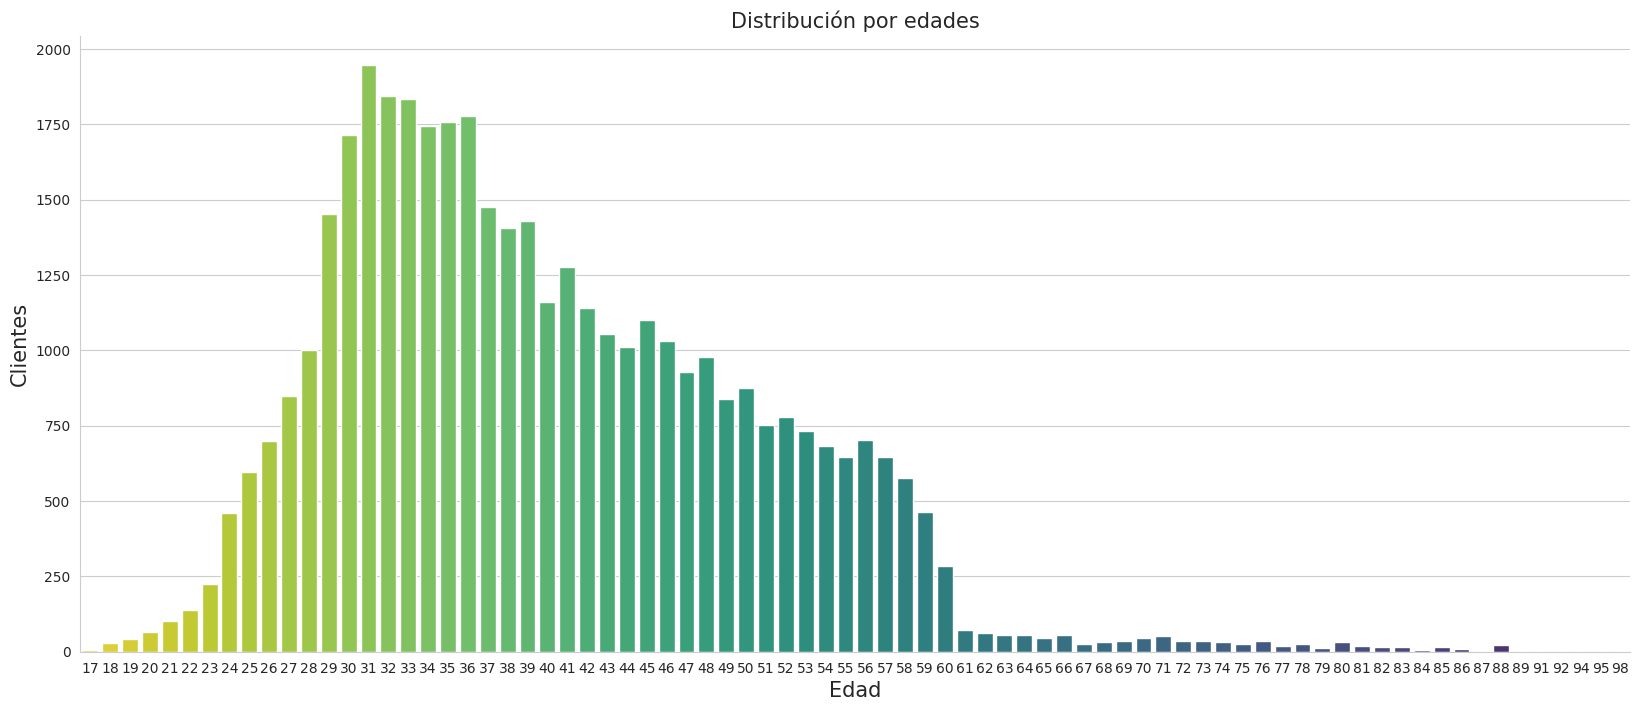

In [198]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x='age', data=df1, hue='age', palette='viridis_r', legend=False)
ax.set_xlabel('Edad', fontsize=15)
ax.set_ylabel('Clientes', fontsize=15)
ax.set_title('Distribución por edades', fontsize=15)
sns.despine()

Observamos que la mayor parte de clientes es de 31 años.

Pregunta: ¿Cuál es el rango de edades relevantes, y cuáles son los valores atípicos u outliers?

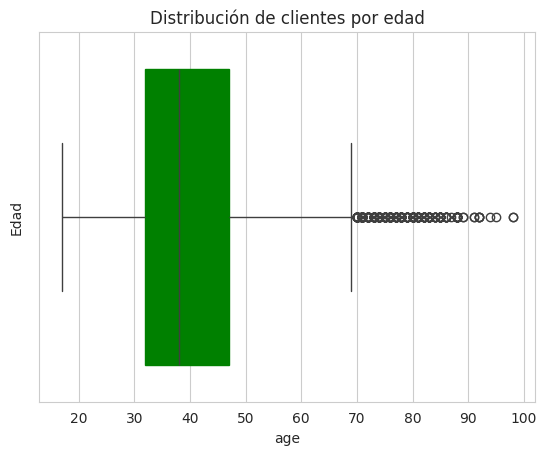

In [199]:
warnings.simplefilter(action='ignore', category=UserWarning)
sns.boxplot(x='age', data=df1, orient='h', boxprops=dict(facecolor='black', color='green'))
plt.title('Distribución de clientes por edad')
plt.ylabel('Clientes')
plt.ylabel('Edad')
plt.show()

Observamos que el rango de edades va desde:

el cuartil 1 = 32

hasta cuartil 3= 47

siendo la mediana= 39.5

Observando el gráfico de caja vemos varios outliers, asique vamos a delimitar a partir de qué valor los consideramos atípicos

Vamos a evaluar el umbral superior como **US= Q3 + 1,5 * (Q3-Q1)**

Así sabemos cuales son considerados outliers.

In [200]:
Q1 = df1['age'].quantile(q = 0.25)
Q3 = df1['age'].quantile(q = 0.75)

umbral_superior = Q3 + 1.5 * (Q3 - Q1)
print('Cuartil 1=', Q1)
print('Cuartil 3=', Q3)
print('Las edades por encima de: ', umbral_superior, 'son outliers')

Cuartil 1= 32.0
Cuartil 3= 47.0
Las edades por encima de:  69.5 son outliers


Pregunta: ¿Qué valor representan estos outliers?

In [201]:
print('Cantidad de outliers: ', df1[df1['age'] > 69.6]['age'].count())
print('Cantidad de clientes: ', len(df1))
#Outliers en porsentaje
print('Porcentaje de outliers:', round(df1[df1['age'] > 69.6]['age'].count()*100/len(df1),2), '%')

Cantidad de outliers:  468
Cantidad de clientes:  41176
Porcentaje de outliers: 1.14 %


Podemos ver que es muy baja la cantidad, por debajo de 1.2%

*Adhesiones por edad*

¿En qué franja de edad se concentran los clientes más propensos a adherirse a un plazo fijo?

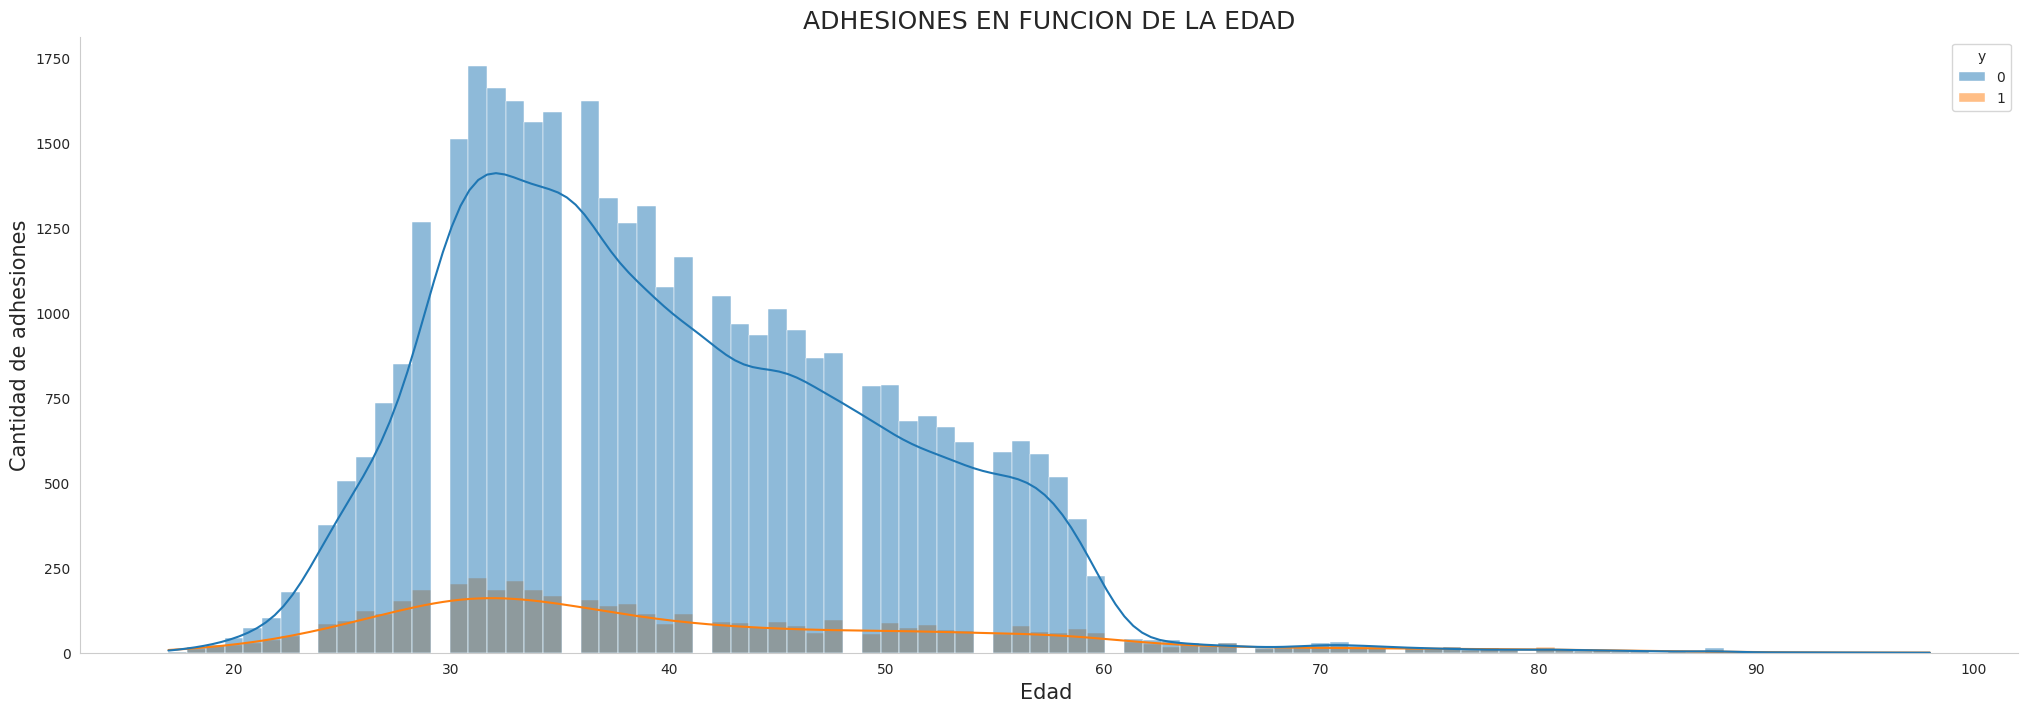

In [202]:
p= sns.histplot(data=df1, kde=True ,x="age", hue= "y")
plt.gcf().set_size_inches(25, 8)
p.set_title("ADHESIONES EN FUNCION DE LA EDAD", fontsize=18)
p.set_xlabel("Edad ", fontsize= 15)
plt.ylabel('Cantidad de adhesiones', fontsize= 15)
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

La mayor cantidad de adhesiones se encuentra en el rango de 30-40 años, por lo que parece existir una relación directa con que la cantidad de clientes de esa franja de edades es la mayor.

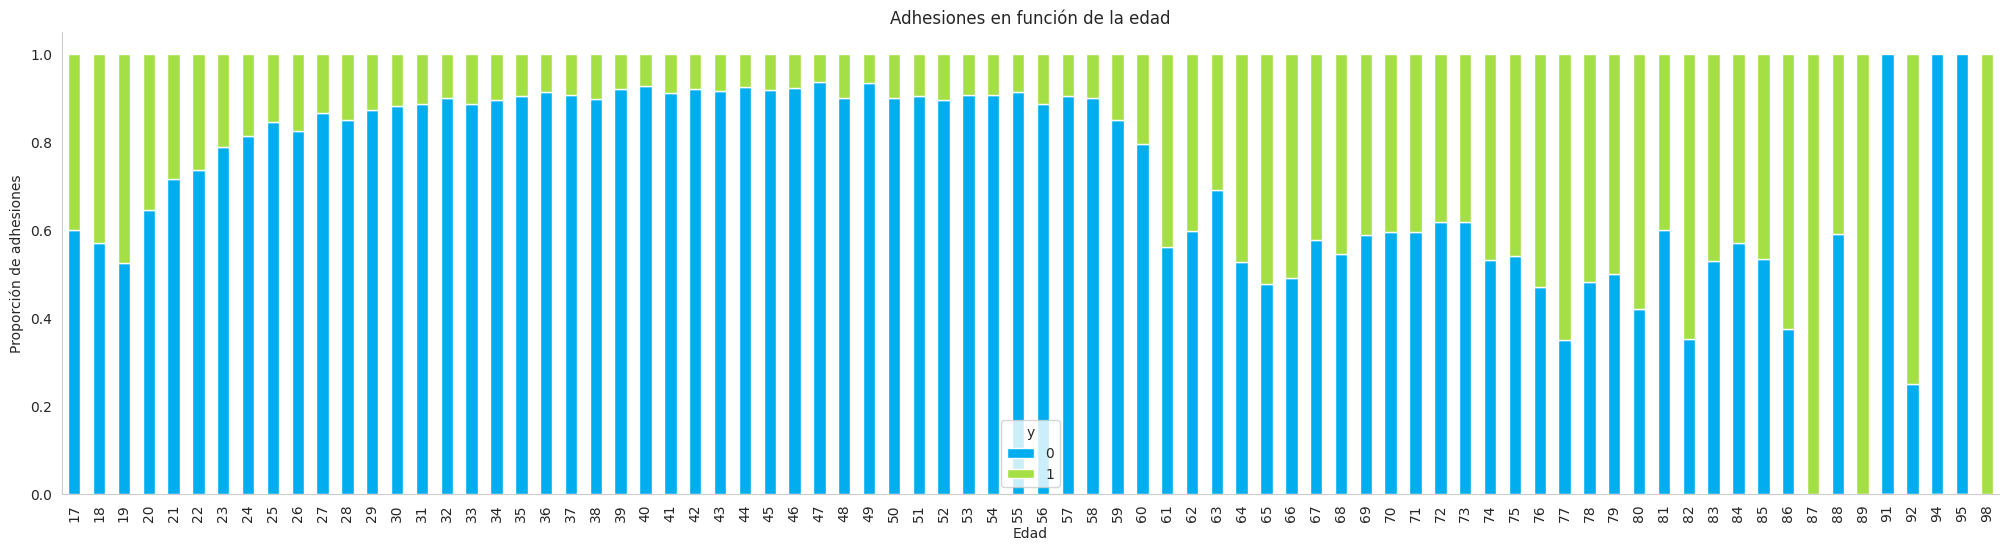

In [203]:
colors=['#00ADEF', '#A4E045']
table=pd.crosstab(df1.age,df1.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=colors)
plt.gcf().set_size_inches(25, 6)
plt.title('Adhesiones en función de la edad')
plt.xlabel('Edad')
plt.ylabel('Proporción de adhesiones')
plt.grid(False)
ax = plt.gcf().gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Aunque la mayoría de las adhesiones se dan en clientes de entre 30 y 40 años (lo cual es lógico porque es el grupo más numeroso), si analizamos la proporción de adhesiones dentro de cada grupo de edad, vemos que los clientes menores de 30 años y mayores de 60 años tienen una mayor tasa de adhesión.

**Ocupaciones**

Vamos a analizar a acerca de los trabajos de los clientes

¿Cuáles son los trabajos de los clientes contactados?

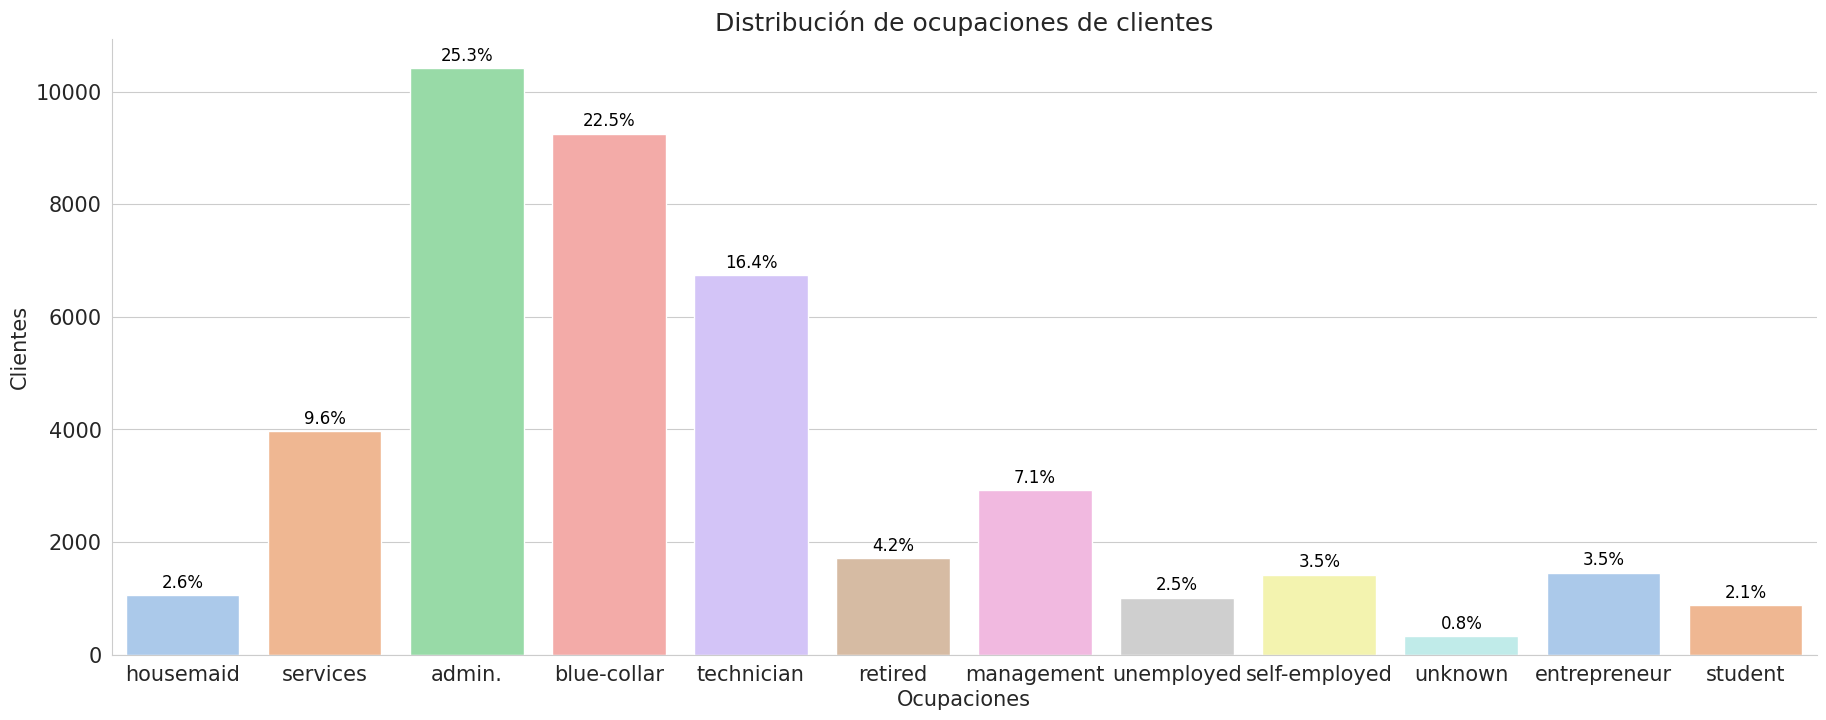

In [204]:
fig, ax = plt.subplots()
fig.set_size_inches(22, 8)
sns.countplot(x='job', data=df1, hue='job', palette='pastel', ax=ax)
total = len(df1)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=12, color='black', xytext=(0, 9), textcoords='offset points')
ax.set_xlabel('Ocupaciones', fontsize=15)
ax.set_ylabel('Clientes', fontsize=15)
ax.set_title('Distribución de ocupaciones de clientes', fontsize=18)
ax.tick_params(labelsize=15)
sns.despine()
plt.show()

Se puede observar que alrededor del 64% de la cartera de clientes está compuesta por personas ocupadas en áreas como la administración, la industria y el sector técnico.

*Analizamos la adhesión a plazo fijo en base a la ocupación*

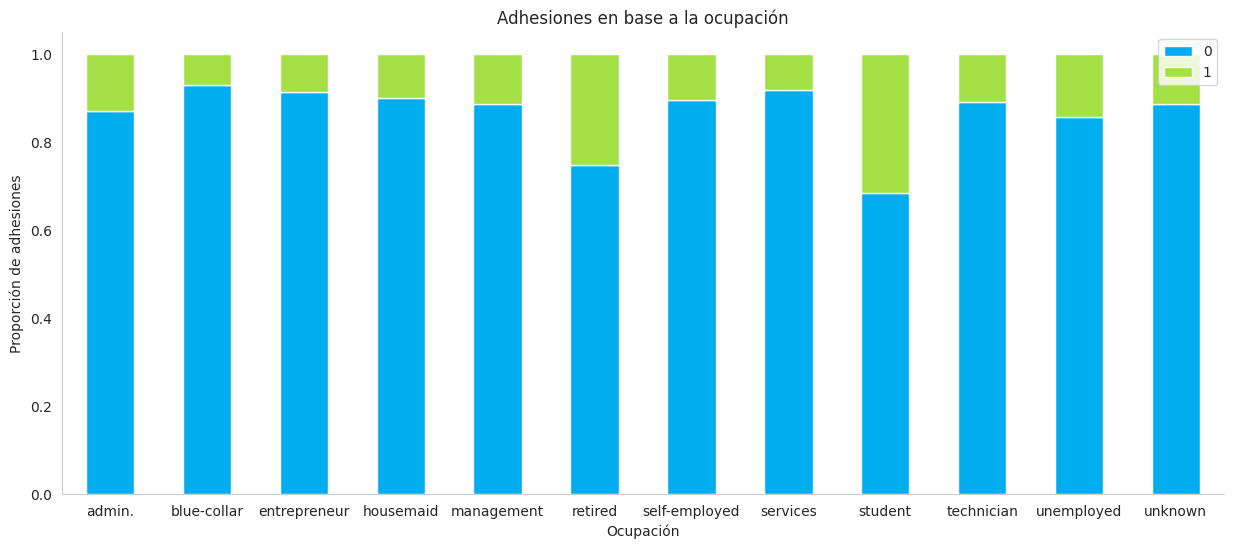

In [205]:
table1=pd.crosstab(df1.job,df1.y)
table1.div(table1.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['#00ADEF', '#A4E045'])
plt.gcf().set_size_inches(15, 6)
plt.title('Adhesiones en base a la ocupación')
plt.xlabel('Ocupación')
plt.ylabel('Proporción de adhesiones')
plt.grid(False)
ax = plt.gcf().gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc="best")
plt.xticks(rotation=0)
plt.show()

La ocupación tiene un impacto significativo en la probabilidad de adherirse a un plazo fijo. Por lo tanto, podemos considerar que la ocupación es una variable útil para predecir la adhesión.

**Estado civil**

¿Cuál es la distribución de estado civil de los clientes?

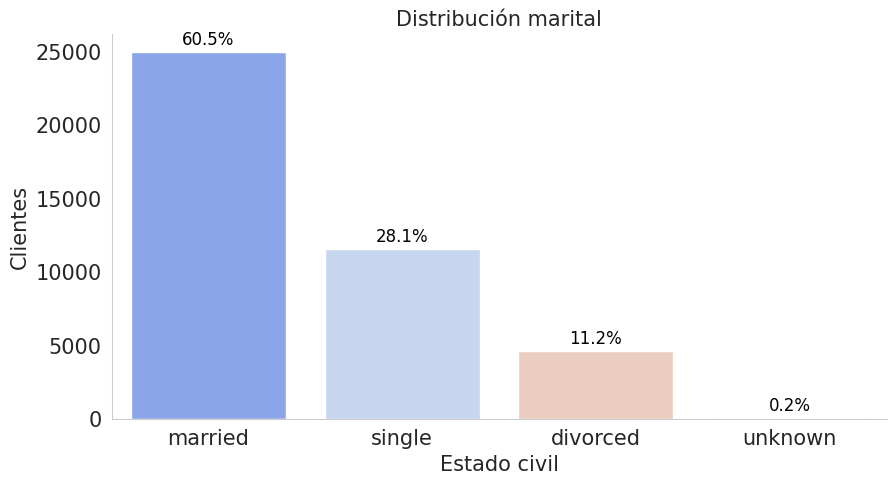

In [208]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.countplot(x = 'marital', data = df1, hue= 'marital', palette='coolwarm')
total = len(df1)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=12, color='black', xytext=(0, 9), textcoords='offset points')
ax.set_xlabel('Estado civil', fontsize=15)
ax.set_ylabel('Clientes', fontsize=15)
ax.set_title('Distribución marital', fontsize=15)
ax.tick_params(labelsize=15)
plt.grid(False)
sns.despine()
plt.show()

Vemos que la mayor parte de los clientes (60.5%) son casados, siguen los solteros con menos de la mitad al anterior, continuan los divorciados y finalmente los que no tenemos datos acerca de sus estados que son la minoría (con una cifra inferior al 1%).

*Analizamos la adhesión al plazo fijo en base al estado civil*

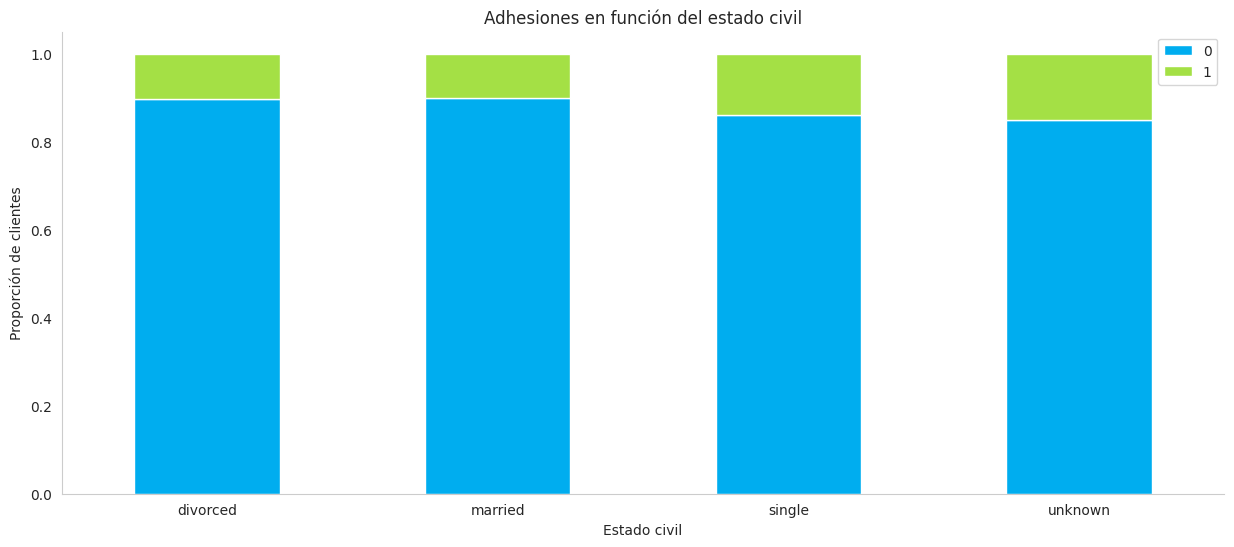

In [209]:
table2=pd.crosstab(df1.marital,df1.y)
table2.div(table2.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['#00ADEF', '#A4E045'])
plt.gcf().set_size_inches(15, 6)
plt.title('Adhesiones en función del estado civil')
plt.xlabel('Estado civil')
plt.ylabel('Proporción de clientes')
plt.grid(False)
ax = plt.gcf().gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc="best")
plt.xticks(rotation=0)
plt.show()

El estado civil de los clientes no parece ser un factor clave para predecir su inclinación o rechazo hacia la adhesión a un Plazo Fijo.

**Educación**

¿Cuál es el nivel de estudios que tienen los clientes?

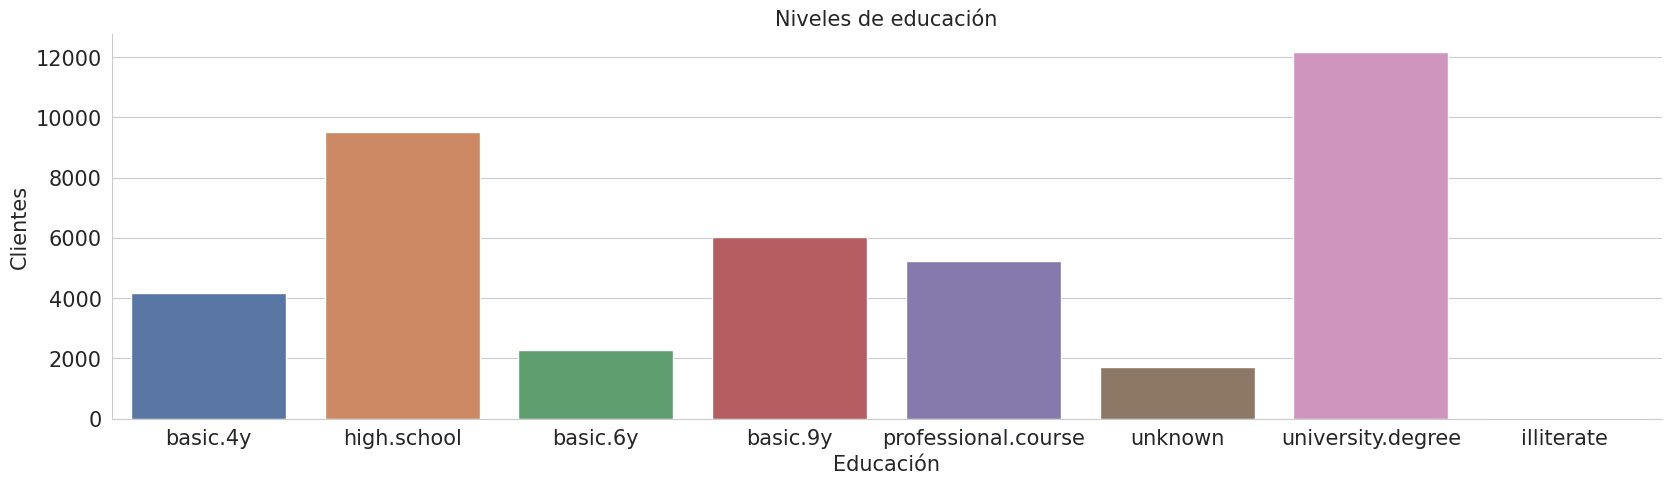

In [210]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.countplot(x = 'education', data = df1,hue='education', palette='deep', legend=False)
ax.set_xlabel('Educación', fontsize=15)
ax.set_ylabel('Clientes', fontsize=15)
ax.set_title('Niveles de educación', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

La variable educación tiene muchos niveles de educación básica, vamos a agruparlos en una única categoría "Basic".

In [211]:
df1.loc[df1['education'].isin(['basic.9y', 'basic.6y', 'basic.4y']), 'education'] = 'Basic'
print('Education:\n', df1['education'].unique())

Education:
 ['Basic' 'high.school' 'professional.course' 'unknown' 'university.degree'
 'illiterate']


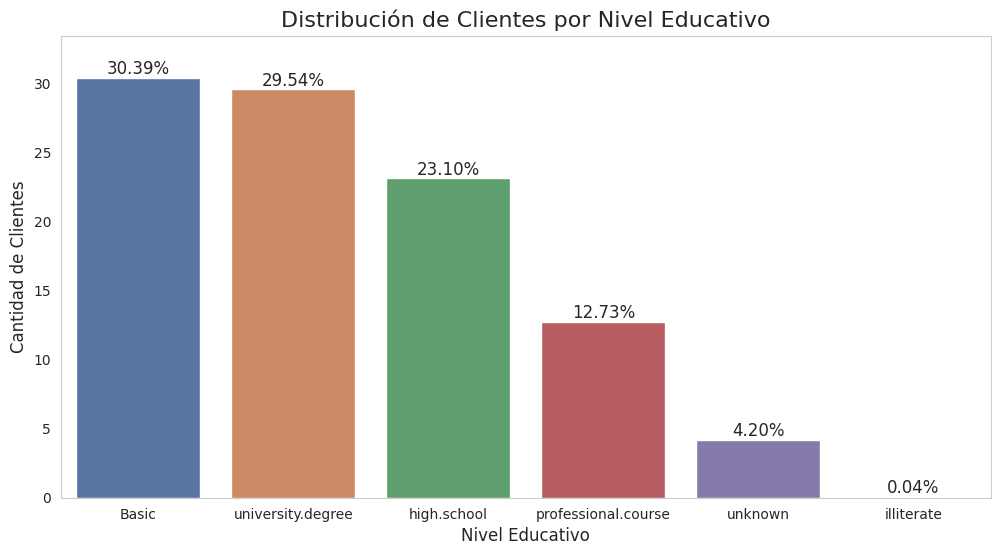

In [212]:
education_counts = df1['education'].value_counts(normalize= True) * 100
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_counts.index, y=education_counts.values, hue= education_counts.index, palette='deep', legend=False)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=12)
plt.xlabel("Nivel Educativo", fontsize=12)
plt.ylabel("Cantidad de Clientes", fontsize=12)
plt.title("Distribución de Clientes por Nivel Educativo", fontsize=16)
plt.ylim(0, max(education_counts.values) * 1.1)
plt.grid(False)
plt.show()

Se puede observar que alrededor del 65% de los clientes del banco está fuertemente instruida con nivel de educación secundaria o superior, de los cuales un 42,27% posee curso profesional o universitario completo.

*Analizamos la adhesión a plazo fijo en base a la educación*

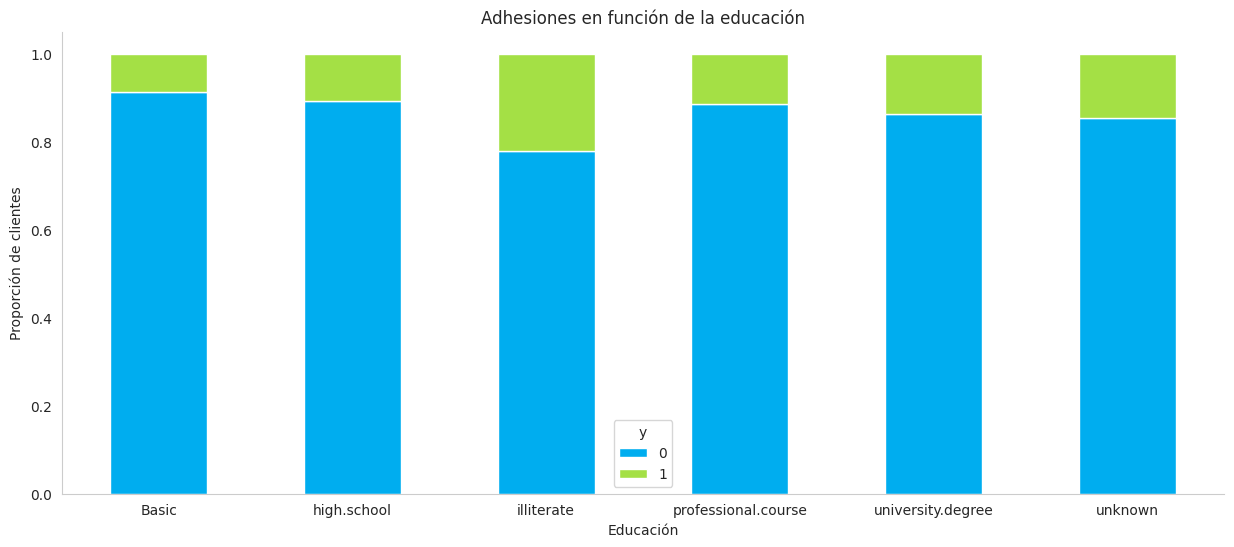

In [213]:
table1=pd.crosstab(df1.education,df1.y)
table1.div(table1.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color= ['#00ADEF', '#A4E045'])
plt.gcf().set_size_inches(15, 6)
plt.title('Adhesiones en función de la educación')
plt.xlabel('Educación')
plt.ylabel('Proporción de clientes')
plt.grid(False)
ax = plt.gcf().gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=0)
plt.show()

La variable referente al nivel de educación podría desempeñar un papel importante como predictor en el modelo.

***Analizamos algunos datos de la campaña***

**Contacto**

*Adhesion en base al tipo de contacto*

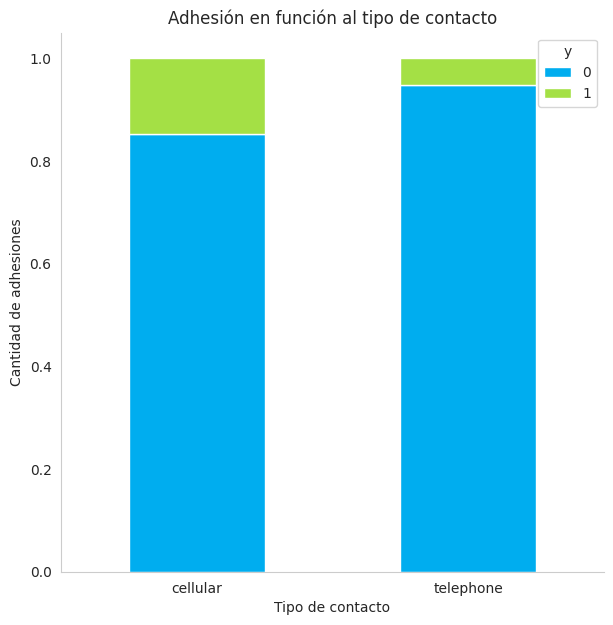

In [214]:
table3= pd.crosstab(df1.contact,df1.y)
table3.div(table3.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color= ['#00ADEF', '#A4E045'])
plt.gcf().set_size_inches(7, 7)
plt.title('Adhesión en función al tipo de contacto')
plt.xlabel('Tipo de contacto')
plt.ylabel('Cantidad de adhesiones')
plt.grid(False)
ax = plt.gcf().gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=0)
plt.show()

El tipo de contacto podría ser un factor relevante para predecir la propensión a la adhesión.

**Día de la semana**

*Adhesión en base al día de la semana en que se estableció el contacto*

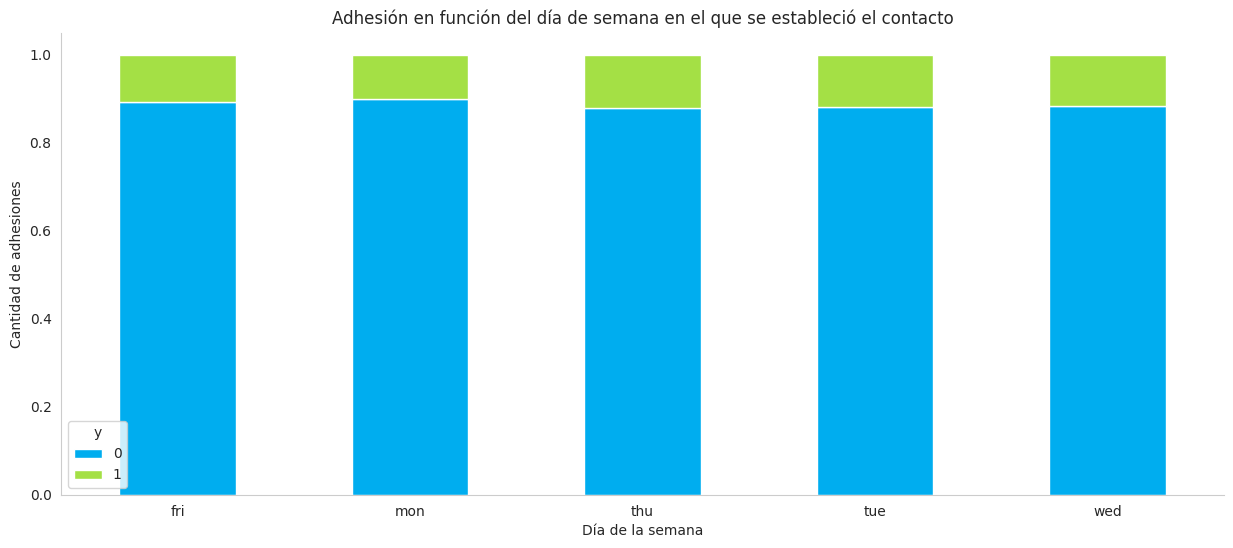

In [215]:
table4= pd.crosstab(df1.day_of_week,df1.y)
table4.div(table4.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color= ['#00ADEF', '#A4E045'])
plt.gcf().set_size_inches(15, 6)
plt.title('Adhesión en función del día de semana en el que se estableció el contacto')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de adhesiones')
plt.grid(False)
ax = plt.gcf().gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=0)
plt.show()

El día de la semana no parece ser un factor relevante.

**Mes**

*Adhesión en base al mes en el que se estableció el contacto*

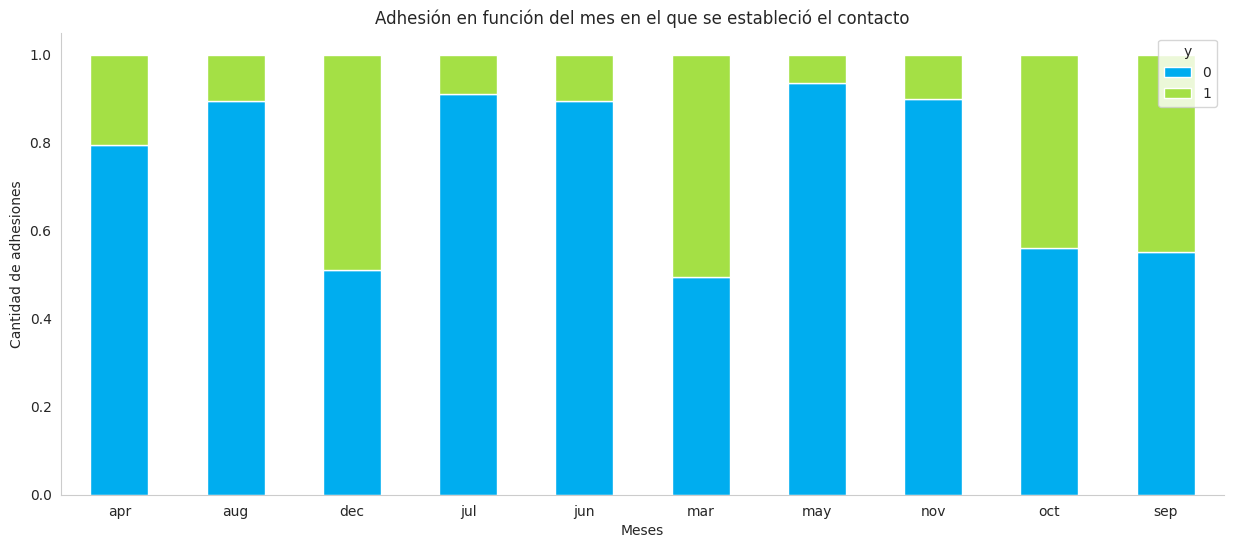

In [216]:
table5= pd.crosstab(df1.month,df1.y)
table5.div(table5.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color= ['#00ADEF', '#A4E045'])
plt.gcf().set_size_inches(15, 6)
plt.title('Adhesión en función del mes en el que se estableció el contacto')
plt.xlabel('Meses')
plt.ylabel('Cantidad de adhesiones')
plt.grid(False)
ax = plt.gcf().gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=0)
plt.show()

El mes en que se generan los contactos si parece ser un factor relevante.

**Campaña**

*Adhesión en base a la cantidad de llamadas*

In [217]:
sorted_num_campaing=sorted(df1.campaign.unique())
print(sorted_num_campaing)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40, 41, 42, 43, 56]


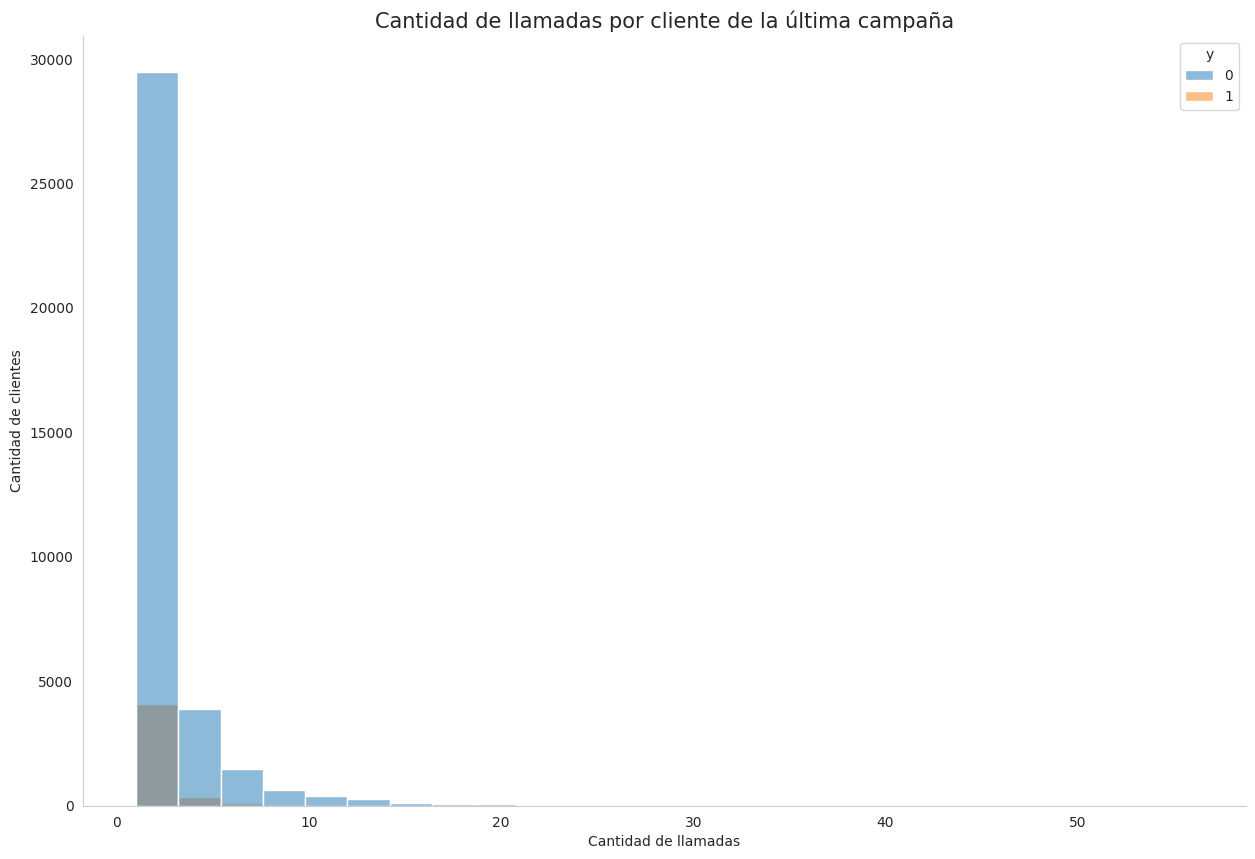

In [219]:
v= sns.histplot(data=df1, x="campaign", hue="y", bins=25)
v.set_title("Cantidad de llamadas por cliente de la última campaña",  fontsize= 15)
plt.gcf().set_size_inches(15, 10)
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Cantidad de clientes')
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Más de la mitad de los clientes fueron contactados solo una vez durante esta campaña, y en este primer contacto se logró concretar la adhesión en la mayoría de los casos. La cantidad de llamados podría ser una variable significativa.

**Campañas Previas**

*Adhesión en base al resultado de campañas anteriores*

In [220]:
df1.previous.unique()
print('Campañas Previas:\n', df1['previous'].unique())

Campañas Previas:
 [0 1 2 3 4 5 6 7]


In [221]:
df_previous= df1[['previous',"poutcome"]].groupby(by=[ "poutcome"]).count().reset_index()
df_previous

,poutcome,previous
0,failure,4252
1,nonexistent,35551
2,success,1373


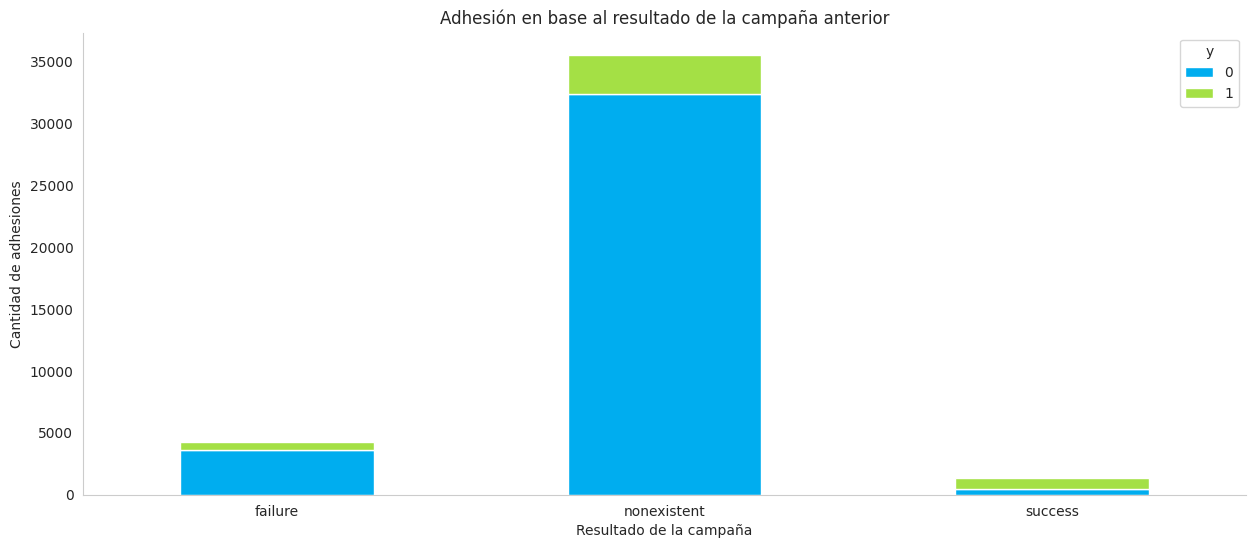

In [222]:
pd.crosstab(df1.poutcome,df1.y).plot(kind='bar', stacked= True, color= ['#00ADEF', '#A4E045'])
plt.gcf().set_size_inches(15, 6)
plt.title('Adhesión en base al resultado de la campaña anterior')
plt.xlabel('Resultado de la campaña')
plt.ylabel('Cantidad de adhesiones')
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=0)
plt.show()

El desempeño en campañas anteriores parece ser un buen indicador para predecir la variable objetivo.

#**INGENIERIA DE FACTORES**

Después de analizar el contexto y obtener una visión inicial, profundizamos en el estudio de las variables para identificar las más relevantes. Aplicamos algunas transformaciones y seleccionamos las variables que emplearemos en el modelo de Machine Learning.

Iniciaríamos utilizando PCA para reducir la dimensionalidad, pero en este caso no es la mejor opción, ya que puede hacer que perdamos interpretabilidad.

 Para un análisis más detallado y una mayor precisión optamos por utilizar el método Wrapper para seleccionar las variables según su impacto en *y*.Posteriormente, aplicamos la matriz de correlación para evitar problemas de multicolinealidad.

**Método Wrapper**

Buscamos seleccionar los mejores atributos para nuestro modelo. Este método evalúa diferentes combinaciones de características y selecciona aquellas que proporcionan el mejor rendimiento del modelo.

In [223]:
df1.keys()

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [224]:
df1.shape

(41176, 21)

In [225]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

Vamos a transformar los atributos son del tipo objeto aplicando Label Encoder para que podamos utilizarlos en esta selección.

In [226]:
le = LabelEncoder()
cols = df1.columns.tolist()
for column in cols:
  if df1[column].dtype == 'object':
    df1[column] = le.fit_transform(df1[column])

In [227]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  int64  
 2   marital         41176 non-null  int64  
 3   education       41176 non-null  int64  
 4   default         41176 non-null  int64  
 5   housing         41176 non-null  int64  
 6   loan            41176 non-null  int64  
 7   contact         41176 non-null  int64  
 8   month           41176 non-null  int64  
 9   day_of_week     41176 non-null  int64  
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  int64  
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

Utilizamos *le* porque es más simple y no aumenta el número de atributos en el dataset, en comparación con One-Hot Encoding.

Separamos la variables independientes en valor de *x*, y la variable target o dependiente (*y*) en valor de *y*.

In [228]:
x= df1.iloc[:,:-1]
y= df1.iloc[:,-1]

Para entrenar este modelo vamos a usar el 80% de los datos, dejando el 20% para la prueba.

In [229]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)
x_train.shape, x_test.shape

((32940, 20), (8236, 20))

Para seleccionar las mejores características basadas en el rendimiento del modelo usaremos SFS.

**SFS - Sequential Forward Selection**

Es un algoritmo que se utiliza dentro para realizar la selección secuencial. Empieza con un modelo sin ninguna característica y, paso a paso, va incorporando una característica a la vez. En cada paso, selecciona la característica que más mejora el rendimiento del modelo. Este proceso continúa hasta que se han agregado todas las características o no se observa mejora en el ajuste al incluir más características.

Selección de características utilizando un modelo de regresión logística.

In [230]:
sfsl = sfs(lgr(max_iter=3000), k_features='best', forward=True, floating=False, verbose=2, scoring='accuracy', cv=0)

In [232]:
sfsl = sfsl.fit(x, y)
selected_features = sfsl.k_feature_names_


[2025-02-06 22:32:49] Features: 1/20 -- score: 0.8975131144355936
[2025-02-06 22:32:51] Features: 2/20 -- score: 0.9058917816203613
[2025-02-06 22:32:55] Features: 3/20 -- score: 0.9078832329512337
[2025-02-06 22:33:01] Features: 4/20 -- score: 0.9080046629104332
[2025-02-06 22:33:06] Features: 5/20 -- score: 0.9085146687390713
[2025-02-06 22:33:16] Features: 6/20 -- score: 0.9090489605595492
[2025-02-06 22:33:34] Features: 7/20 -- score: 0.9097046823392267
[2025-02-06 22:34:35] Features: 8/20 -- score: 0.9107246939965028
[2025-02-06 22:37:04] Features: 9/20 -- score: 0.9107975519720225
[2025-02-06 22:37:37] Features: 10/20 -- score: 0.9109189819312221
[2025-02-06 22:38:49] Features: 11/20 -- score: 0.9109675539149019
[2025-02-06 22:40:16] Features: 12/20 -- score: 0.9108461239557023
[2025-02-06 22:42:11] Features: 13/20 -- score: 0.9110404118904216
[2025-02-06 22:43:52] Features: 14/20 -- score: 0.9111132698659413
[2025-02-06 22:45:28] Features: 15/20 -- score: 0.911186127841461
[202

Analizaremos cómo evolucionó la selección de características y cuál fue el mejor subconjunto.

In [233]:
sfsl.subsets_

{1: {'feature_idx': (12,),
  'cv_scores': array([0.89751311]),
  'avg_score': 0.8975131144355936,
  'feature_names': ('pdays',)},
 2: {'feature_idx': (10, 12),
  'cv_scores': array([0.90589178]),
  'avg_score': 0.9058917816203613,
  'feature_names': ('duration', 'pdays')},
 3: {'feature_idx': (10, 12, 18),
  'cv_scores': array([0.90788323]),
  'avg_score': 0.9078832329512337,
  'feature_names': ('duration', 'pdays', 'euribor3m')},
 4: {'feature_idx': (4, 10, 12, 18),
  'cv_scores': array([0.90800466]),
  'avg_score': 0.9080046629104332,
  'feature_names': ('default', 'duration', 'pdays', 'euribor3m')},
 5: {'feature_idx': (4, 10, 12, 17, 18),
  'cv_scores': array([0.90851467]),
  'avg_score': 0.9085146687390713,
  'feature_names': ('default',
   'duration',
   'pdays',
   'cons.conf.idx',
   'euribor3m')},
 6: {'feature_idx': (4, 10, 12, 17, 18, 19),
  'cv_scores': array([0.90904896]),
  'avg_score': 0.9090489605595492,
  'feature_names': ('default',
   'duration',
   'pdays',
   'cons

Vemos que el subconjunto 16 es el que mayo avg_score tiene, por esto entendemos que es el más optimo para utilizar.
Vamos a extraer los 16 atributos que lo componen.

In [235]:
subset_16 = sfsl.subsets_[16]
feature_names_16 = subset_16["feature_names"]
feature_idx_16 = subset_16["feature_idx"]
print("Nombres de las variables:", feature_names_16)
print("Índices de las variables:", feature_idx_16)

Nombres de las variables: ('age', 'job', 'default', 'housing', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed')
Índices de las variables: (0, 1, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19)


Veremos si elegir este subconjunto es correcto utilizando estas funciones que extraen el mejor subconjunto según el criterio de selección usado por el algoritmo.

In [245]:
best_feature_names = sfsl.k_feature_names_
best_feature_idx = sfsl.k_feature_idx_
print("Mejor subconjunto de variables:", best_feature_names)
print("Índices de las variables:", best_feature_idx)

Mejor subconjunto de variables: ('age', 'job', 'default', 'housing', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed')
Índices de las variables: (0, 1, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19)


Afirmamos que el subconjunto 16 es el más optimo para seguir.

Examinamos la correlación entre las variables, usando la matriz de correlación.

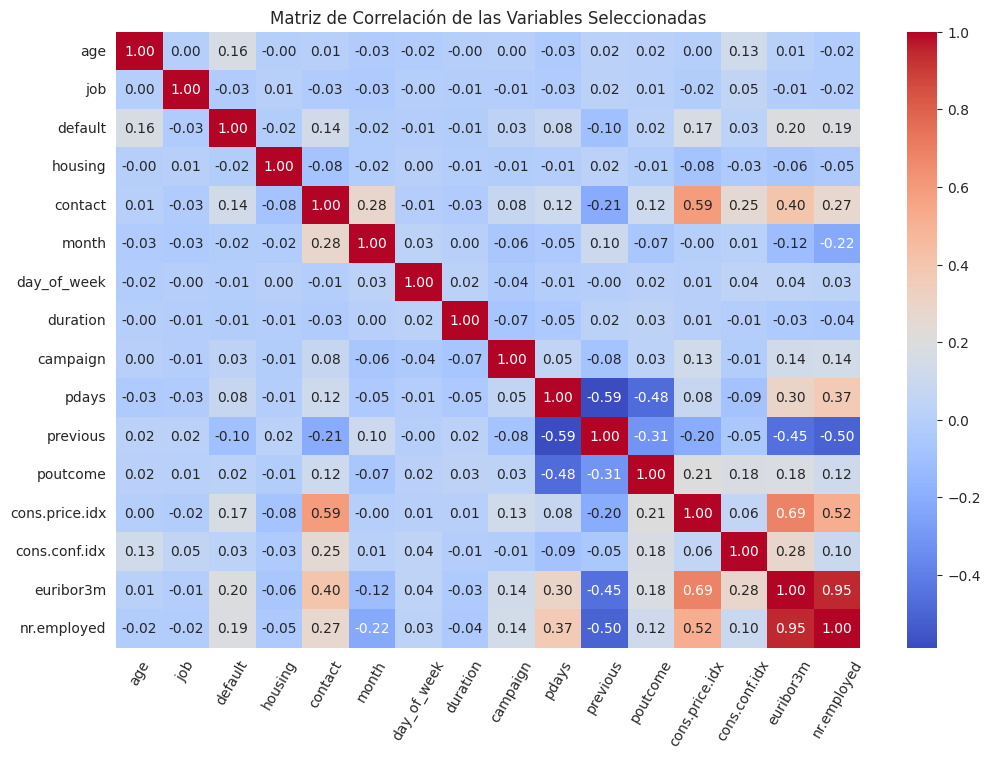

In [250]:
selected_features = list(sfsl.k_feature_names_)
corrm = x[selected_features].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corrm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación de las Variables Seleccionadas')
plt.xticks(rotation=60)
plt.show()

Vemos que hay fuerte correlación entre las variables: *'nr.employed'* y *'euroborn3m'.*

Después de calcular la matriz de correlación, el siguiente paso es analizar si esas correlaciones son estadísticamente significativas. Es decir, si la relación entre dos variables ocurre por casualidad o si es una relación real en los datos.

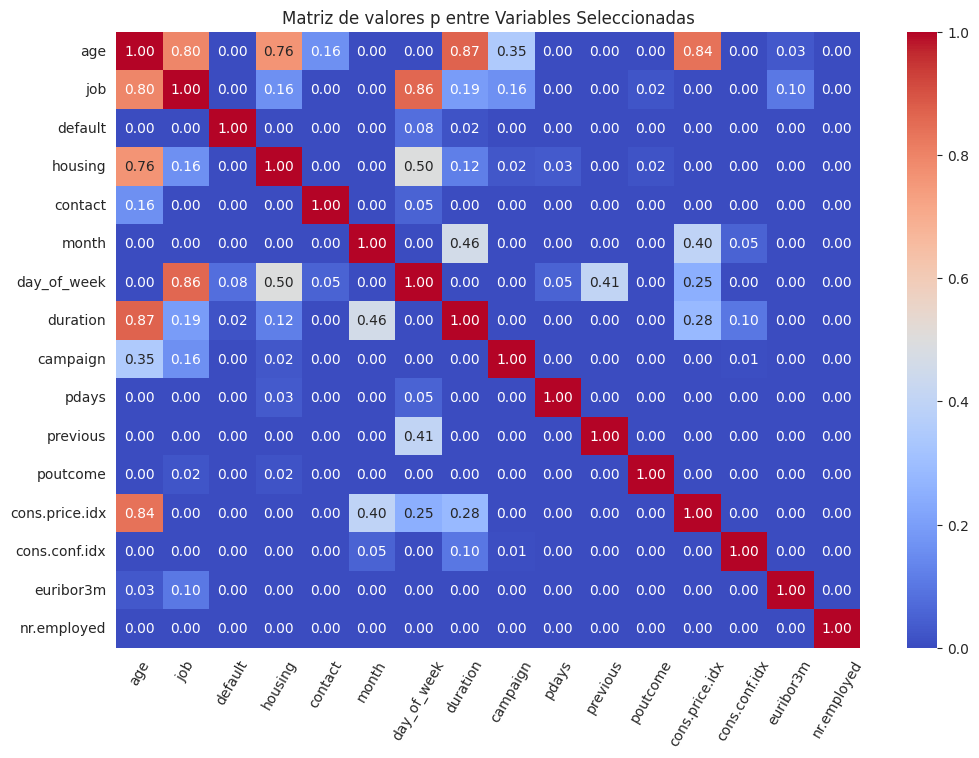

In [262]:
corr_matrix = df1[selected_features].corr()
pval_matrix = np.ones_like(corr_matrix)
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        _, pval_matrix[i, j] = pearsonr(df1[selected_features].iloc[:, i], df1[selected_features].iloc[:, j])
        pval_matrix[j, i] = pval_matrix[i, j]
pval_df = pd.DataFrame(pval_matrix, columns=corr_matrix.columns, index=corr_matrix.columns)
plt.figure(figsize=(12, 8))
sns.heatmap(pval_df, annot=True, cmap= 'coolwarm', fmt=".2f")
plt.title("Matriz de valores p entre Variables Seleccionadas")
plt.xticks(rotation=60)
plt.show()

Viendo que los p-valores son 0, podemos concluir que las correlaciones observadas en la matriz de correlación son estadísticamente significativas, lo que indica que las relaciones entre las variables no son casualidad. Esto sugiere que las correlaciones son reales y tienen una alta probabilidad de ser replicables en cualquier muestra representativa de los datos.

In [264]:
significancia = {}
for col1 in df1.columns:
    for col2 in df1.columns:
        if col1 != col2:
            corr, p_value = pearsonr(df1[col1], df1[col2])
            significancia[(col1, col2)] = p_value
for pair, p in significancia.items():
    if p < 0.05:
        print(f"Correlación significativa entre {pair[0]} y {pair[1]} (p-valor: {p:.4f})")

Correlación significativa entre age y marital (p-valor: 0.0000)
Correlación significativa entre age y education (p-valor: 0.0000)
Correlación significativa entre age y default (p-valor: 0.0000)
Correlación significativa entre age y month (p-valor: 0.0000)
Correlación significativa entre age y day_of_week (p-valor: 0.0004)
Correlación significativa entre age y pdays (p-valor: 0.0000)
Correlación significativa entre age y previous (p-valor: 0.0000)
Correlación significativa entre age y poutcome (p-valor: 0.0001)
Correlación significativa entre age y cons.conf.idx (p-valor: 0.0000)
Correlación significativa entre age y euribor3m (p-valor: 0.0277)
Correlación significativa entre age y nr.employed (p-valor: 0.0004)
Correlación significativa entre age y y (p-valor: 0.0000)
Correlación significativa entre job y marital (p-valor: 0.0000)
Correlación significativa entre job y education (p-valor: 0.0000)
Correlación significativa entre job y default (p-valor: 0.0000)
Correlación significativa en

La alta significancia (p-valor cercano a 0) nos permite quedarnos con una sola de estas 2 variables que tienen alta correlación. Nos quedamos con la variable 'euribor3m', eliminando 'nr.employed'.

In [267]:
if 'nr.employed' in selected_features:
    selected_features.remove('nr.employed')

print(selected_features)

['age', 'job', 'default', 'housing', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']


**Modelo: Random Forest**

Utilizaremos este algoritmo porque es un conjunto de árboles de decisión combinados. Lo que lo diferencia del arbol de decision es que distintos árboles ven distintas porciones de los datos. Ningún árbol ve todos los datos de entrenamiento. Esto hace que cada árbol se entrene con distintas muestras de datos para un mismo problema. De esta forma, al combinar sus resultados, unos errores se compensan con otros y tenemos una predicción que generaliza mejor.

Entrenamiento del modelo con variables seleccionadas (*selected_features*).
Utilizando el 80% de los datos para entrenarlo, y 20% para pruebas.

In [306]:
x_selected = x[selected_features]
x_train, x_test, y_train, y_test = train_test_split(x_selected, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("La precisión del modelo es:", accuracy)

La precisión del modelo es: 0.9123360854783875


In [288]:
print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7265
           1       0.67      0.51      0.58       971

    accuracy                           0.91      8236
   macro avg       0.80      0.74      0.76      8236
weighted avg       0.90      0.91      0.91      8236



Clase 0 (*y*=0):

Precisión: 94%, lo que significa que el modelo tiene una tasa muy alta de predicciones correctas para esta clase.

Recall (Sensibilidad): indica que el modelo logra detectar el 97% de los ejemplos de la clase 0.

F1-score: 95%, que es una métrica combinada de precisión y recall. Dado que F1-score es bastante alto, esto indica que la clase 0 está muy bien predicha.

Clase 1 (*y*=1):

Precisión: solo el 67% de las veces que el modelo predice la clase 1 es correcto. Esto sugiere que el modelo está cometiendo varios falsos positivos en esta clase.

Recall: solo el 51% de las instancias de la clase 1 son correctamente identificadas por el modelo. Es un valor relativamente bajo, lo que indica que el modelo está perdiendo muchos ejemplos de la clase 1 (falsos negativos).

F1-score: 58%, que es bastante bajo en comparación con la clase 0, lo que refuerza la idea de que el modelo tiene dificultades con esta clase.

In [289]:
print(confusion_matrix(y_test, model.predict(x_test)))

[[7020  245]
 [ 477  494]]


Matriz de confusión:

Clase 0 : 7020 verdaderos negativos, 245 falsos positivos

Clase 1: 477 falsos negativos, 494 verdaderos positivos

Con estas observaciones debemos optimizar el modelo.

**Optimización del modelo**

Se aplica la técnica de Oversampling SMOTE, de manera de compensar el desbalance de la variable target. Se elaboró una división entre Test/Train con el mismo porcentaje que se había utilizado anteriormente para ambos modelos, con la diferencia que ahora la cantidad de positivos y negativos en la variable target es la misma.

*SMOTE (Synthetic Minority Oversampling Technique)*

In [307]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [310]:
x = df1[selected_features]
y = df1['y']

smote = SMOTE(k_neighbors=3, random_state=42)
x_smote, y_smote = smote.fit_resample(x, y)

print('Dataset original shape:', Counter(y))
print('Dataset modificado shape:', Counter(y_smote))

Dataset original shape: Counter({0: 36537, 1: 4639})
Dataset modificado shape: Counter({0: 36537, 1: 36537})


In [311]:
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.20, random_state=42)

In [312]:
x_train.shape, x_test.shape

((58459, 15), (14615, 15))

**Random Forest Optimizado**

Utilizamos nuevamente el modelo elegido, pero optimizado para ver si tenemos mejores resultados.
Entrenandolo con hiperparámetros.

In [313]:
clf2 = RandomForestClassifier(max_depth=10, random_state=42, n_estimators=50,criterion='gini')
clf2.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

In [316]:
y_pred= clf2.predict(x_test)
print(classification_report( y_pred=y_pred, y_true= y_test))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      7348
           1       0.91      0.96      0.93      7267

    accuracy                           0.93     14615
   macro avg       0.93      0.93      0.93     14615
weighted avg       0.93      0.93      0.93     14615



In [330]:
accuracy_opt = accuracy_score(y_test, y_pred)
print("La nueva precisión del modelo es:", accuracy_opt)

La nueva precisión del modelo es: 0.9323982210058159


<Figure size 1500x900 with 0 Axes>

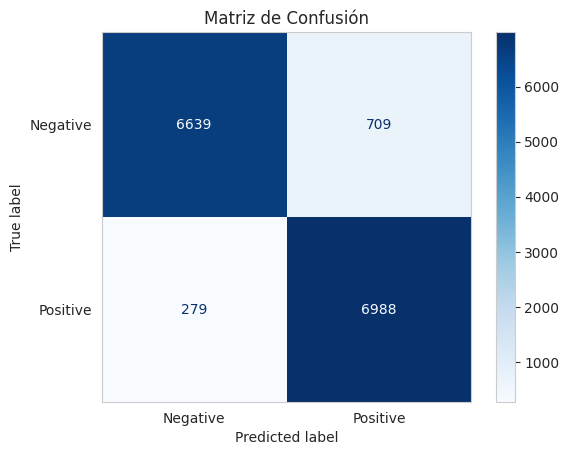

In [321]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
sns.set_style('whitegrid')
plt.figure(figsize=(15,9))
cm = confusion_matrix(y_test, clf2.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap="Blues", values_format=".0f")
plt.title("Matriz de Confusión")
plt.grid(False)
plt.show()

Finalmente analizamos la curva AUC - ROC.

In [322]:
y_score1 = clf2.predict_proba(x_test)[:,1]
y_score1

array([0.00603408, 0.68298618, 0.98274272, ..., 0.06866862, 0.25114852,
       0.03231742])

In [323]:
clf2.predict_proba(x_test)

array([[0.99396592, 0.00603408],
       [0.31701382, 0.68298618],
       [0.01725728, 0.98274272],
       ...,
       [0.93133138, 0.06866862],
       [0.74885148, 0.25114852],
       [0.96768258, 0.03231742]])

In [325]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
print('roc_auc_score for RandomForest: ', roc_auc_score(y_test, y_score1))

roc_auc_score for RandomForest:  0.9820355442335988


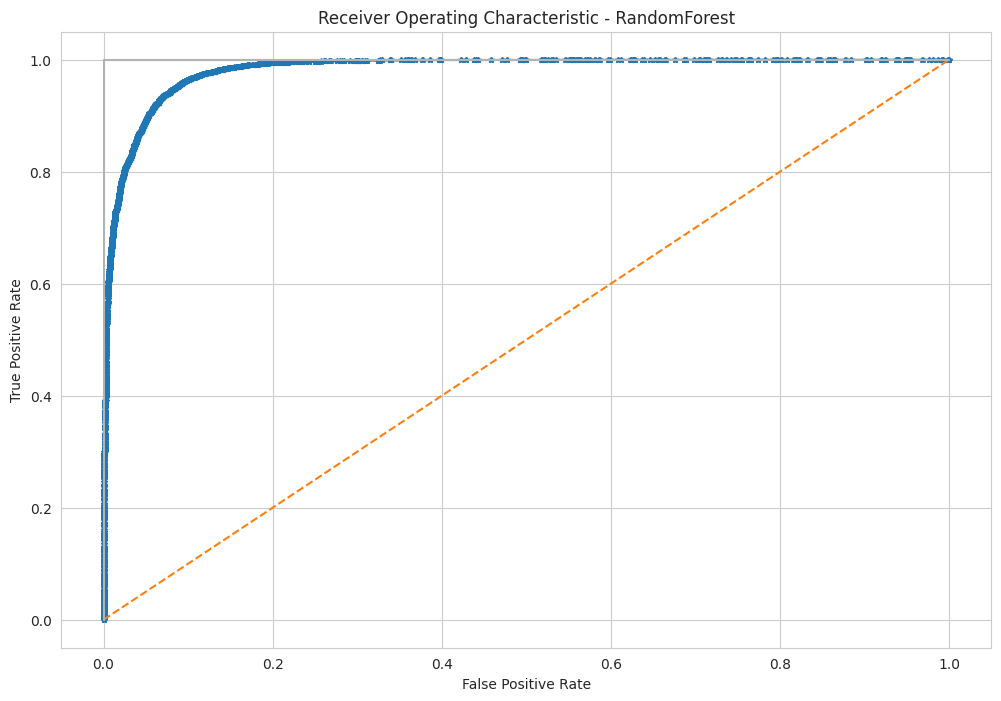

In [327]:
plt.subplots(1, figsize=(12,8))
plt.title('Receiver Operating Characteristic - RandomForest')
plt.plot(false_positive_rate1, true_positive_rate1,marker='*', markersize=4)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#**Conclusión**

El Radom Forest nos ofrece un rendimiento de un 93% en cuanto a la clasificación de los resultados por lo que podríamos decir que es un algoritmo confiable. Aun así entendemos que podríamos seguir mejorando nuestro dataset para conseguir una fiabilidad mayor. Todo esto con más limpieza de los datos e ingeniería de atributos.

La precisión es del 96% para detectar clientes que no son propensos a la adhesión a un plazo fijo y del 91% para aquellos que si lo son.

La sensibilidad es de un 96%, buen valor como para decir que el modelo detecta a las personas propensas a suscribirse a un plazo fijo.

La especificidad arroja un 90%, podríamos considerar que el modelo también es bueno en detectar las personas adversas a la suscripción a un plazo fijo.

La métrica F1Score (balance entre especificidad y sensibiidad) de 93% también da bastante buena.

Finalmente entendemos que se podría seguir mejorando nuestro dataset y volver a entrenar el modelo.